In [1]:
import re

import pandas as pd
import geopandas as gpd
import ultraplot as uplt
import numpy as np
from scipy.stats import pearsonr
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error

## Combine anomaly files into one csv

In [2]:
for year in [2020, 2021, 2022, 2023]:
    # Load all of the precipitation data and merge into one dataframe
    prcp_df = gpd.read_file(f'./Data/TimeImpacts/prcp_grid_{year}_month_1.geojson')
    for i in range(2, 25):
        temp_df = gpd.read_file(f'./Data/TimeImpacts/prcp_grid_{year}_month_{i}.geojson')
        prcp_df = prcp_df.merge(temp_df, how='inner', on='id', suffixes=(f'_{i-1}', f'_{i}'))
    prcp_df = prcp_df.drop(columns=[f'geometry_{i}' for i in range(1, 25)])
    
    # Load all of the precipitation data and merge into one dataframe
    tmax_df = gpd.read_file(f'./Data/TimeImpacts/tmax_grid_{year}_month_1.geojson')
    for i in range(2, 25):
        temp_df = gpd.read_file(f'./Data/TimeImpacts/tmax_grid_{year}_month_{i}.geojson')
        tmax_df = tmax_df.merge(temp_df, how='inner', on='id', suffixes=(f'_{i-1}', f'_{i}'))
    tmax_df = tmax_df.drop(columns=[f'geometry_{i}' for i in range(1, 25)])
    
    full_df = gpd.read_file(f'./Data/TimeImpacts/forest_grid_{year}.geojson')
    full_df = full_df.merge(prcp_df, how='inner', left_on='id', right_on='id')
    full_df = full_df.merge(tmax_df, how='inner', on='id')
    full_df = full_df.drop('id', axis=1)
    full_df['defol_forest_2'] = full_df['defoliation_2']/full_df['forest']
    full_df['defol_forest_mask_2'] = full_df['defoliation_2']/full_df['qa_mask_2']
    full_df['defol_forest_3'] = full_df['defoliation_3']/full_df['forest']
    full_df['defol_forest_mask_3'] = full_df['defoliation_3']/full_df['qa_mask_3']
    full_df.to_file(f'./Data/TimeImpacts/time_lags_months_{year}.geojson')

## Load data

In [3]:
prcp_anom_cols = [f'prcp_anom_{i}' for i in range(1, 25)]
tmax_anom_cols = [f'tmax_anom_{i}' for i in range(1, 25)]
prcp_mean_cols = [f'prcp_mean_{i}' for i in range(1, 25)]
tmax_mean_cols = [f'tmax_mean_{i}' for i in range(1, 25)]
days_cols = [f'days_{i}_x' for i in range(1, 25)]

In [4]:
df_2020 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2020.geojson')

df_2021 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2021.geojson')

df_2022 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2022.geojson')

df_2023 = gpd.read_file('./Data/TimeImpacts/time_lags_months_2023.geojson')

full_df = gpd.GeoDataFrame(pd.concat([df_2021, df_2023], ignore_index=True, axis=0), crs=df_2021.crs)

In [5]:
# Logit transform defol_forest_3 before doing analysis
#full_df['logit_defol_forest_3'] = np.log(0.00000000000001 + full_df['defol_forest_3']/(1-full_df['defol_forest_3']))

#full_df = full_df[full_df['defol_forest_3'] > 0]

## Helper functions

In [6]:
def calc_window(df, cols, prefix, i, j):
    # Aggregates specified columns. Return new dataframe and name of column appended.
    agg = df[cols[i]].copy()
    for k in range(i+1, j+1):
        agg += df[cols[k]]
    return agg.rename(f'{prefix}_{i+1}_{j+1}'), f'{prefix}_{i+1}_{j+1}'

def calc_all_window(df, cols, prefix, min_length, max_length):
    # Aggregates all windows up to a provide size. Returns new data frame and a list of names of all columns appended.
    new_cols = []
    new_cols_names = []
    for length in range(min_length, max_length+1):
        for i in range(0, 24-length):
            new_col, new_col_name = calc_window(df, cols, prefix, i, i+length)
            new_cols.append(new_col)
            new_cols_names.append(new_col_name)
    new_cols_df = pd.concat(new_cols, names=new_cols_names, axis=1)
    df = pd.concat([df, new_cols_df], axis=1)
    return df, new_cols_names

In [7]:
def partial_regression(ax, data, x_residual, x_initial, y, xlabel, mls_pvalue, ms=10, ls='dashed'):
    # Compute x residuals
    formula = x_residual + ' ~ ' + ' + '.join(x_initial)
    x_reg = sm.ols(formula=formula, data=data).fit()

    predicted = x_reg.params['Intercept']
    for x in x_initial:
        predicted += x_reg.params[x]*data[x]
    data['x_residuals'] = data[x_residual] - predicted
    
    # Compute y residuals
    formula = y + ' ~ ' + ' + '.join(x_initial)
    y_reg = sm.ols(formula=formula, data=data).fit()
    
    predicted = y_reg.params['Intercept']
    for x in x_initial:
        predicted += y_reg.params[x]*data[x]
    data['y_residuals'] = data[y] - predicted
    
    # Compute partial regression
    res_reg = sm.ols('y_residuals ~ x_residuals', data=data).fit()

    # Plot residuals
    ax.scatter(data['x_residuals'], data['y_residuals'], color='gray', markersize=ms)

    x = np.array(ax.get_xlim())
    y_pred = res_reg.params['Intercept'] + res_reg.params['x_residuals']*x

    print(res_reg.params['x_residuals'])

    # Plot partial regression
    ax.plot(x, y_pred, color='black', linestyle=ls)
    ax.format(xlabel=xlabel, ylabel='Residuals',
              upperrighttitle=f'slope={res_reg.params['x_residuals']:.4f}\np={mls_pvalue:.4f}')

## Create partial regression plots

In [8]:
# Select strongest correlation periods for both precipitation anomaly and max temp anomaly.
full_df['prcp_anom_10_12'] = calc_window(full_df, prcp_anom_cols, 'prcp_anom', 9, 11)[0]
full_df['tmax_anom_10_10'] = calc_window(full_df, tmax_anom_cols, 'tmax_anom', 9, 9)[0]
full_df['days_10_10'] = calc_window(full_df, days_cols, 'days', 9, 9)[0]
full_df['tmax_anom_reg_10_10'] = full_df['tmax_anom_10_10']/full_df['days_10_10']
# Fraction deciduous as a rough approximation for palatability.
full_df['frac_deciduous'] = full_df['deciduous'] / full_df['forest']
# Calculate mean prcp/temp for several periods to decide which is most important.
full_df['prcp_mean_spring'] = calc_window(full_df, prcp_mean_cols, 'prcp_mean', 12, 14)[0]
full_df['prcp_mean_growing_season'] = calc_window(full_df, prcp_mean_cols, 'prcp_mean', 8, 12)[0]
full_df['prcp_mean_annual'] = calc_window(full_df, prcp_mean_cols, 'prcp_mean', 5, 16)[0]
full_df['tmax_mean_spring'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 12, 14)[0]
full_df['tmax_mean_growing_season'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 8, 12)[0]
full_df['tmax_mean_annual'] = calc_window(full_df, tmax_mean_cols, 'tmax_mean', 5, 16)[0]
full_df['days_spring'] = calc_window(full_df, days_cols, 'days', 12, 14)[0]
full_df['days_growing_season'] = calc_window(full_df, days_cols, 'days', 8, 12)[0]
full_df['days_annual'] = calc_window(full_df, days_cols, 'days', 5, 16)[0]
# Regularize tmax so it is in terms of daily mean maximum temperature instead of cumulative
full_df['tmax_mean_reg_spring'] = full_df['tmax_mean_spring']/full_df['days_spring']
full_df['tmax_mean_reg_growing_season'] = full_df['tmax_mean_growing_season']/full_df['days_growing_season']
full_df['tmax_mean_reg_annual'] = full_df['tmax_mean_annual']/full_df['days_annual']

C:\Users\camer\miniforge3\envs\defoliation\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\camer\miniforge3\envs\defoliation\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
C:\Users\camer\miniforge3\envs\defoliation\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

In [9]:
min_prop = 3/4
full_df['suf_obs'] = full_df['qa_mask_3']/full_df['forest'] >= min_prop
full_df_masked = full_df[full_df['suf_obs']].copy()

C:\Users\camer\miniforge3\envs\defoliation\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [10]:
factors = ['prcp_anom_10_12',
           'tmax_anom_reg_10_10',
           'frac_deciduous',
           'prcp_mean_annual',
           'tmax_mean_reg_annual']
factor_names = ['Precipitation Anomaly',
                'Max. Temperature Anomaly',
                'Frac. Deciduous Forest',
                'Annual Mean Precipitation',
                'Annual Mean Max. Tempearture']
mod_annual = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(factors), data=full_df_masked)

res_annual = mod_annual.fit()

print(res_annual.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_3   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     35.24
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           1.30e-34
Time:                        09:54:48   Log-Likelihood:                 2855.3
No. Observations:                1955   AIC:                            -5699.
Df Residuals:                    1949   BIC:                            -5665.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0643 

In [11]:
_, qs = fdrcorrection(list(res_annual.pvalues.iloc[1:]), 
              alpha=0.1, method='indep', is_sorted=False)

In [12]:
# Calculate partial r2
pr2 = []
ssr_complete = res_annual.ssr
for factor in factors:
    reduced_factors = [f for f in factors if f != factor]
    mod_reduced = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(reduced_factors), data=full_df_masked)
    res_reduced = mod_reduced.fit()
    ssr_reduced = res_reduced.ssr
    pr2.append((ssr_reduced - ssr_complete) / ssr_reduced)

In [13]:
print("Coefficient\tConfidence Interval\tP-value\tQ-value\tPartial R^2")
print(f"{res_annual.params.iloc[0]:.2E}\t" +
      f"({res_annual.conf_int().iloc[0][0]:.2E}, " +
      f"{res_annual.conf_int().iloc[0][1]:.2E})\t" +
      f"{res_annual.pvalues.iloc[0]:.2E}\t")
for i in range(1, len(res_annual.params)):
    print(f"{res_annual.params.iloc[i]:.2E}\t" +
          f"({res_annual.conf_int().iloc[i][0]:.2E}, " +
          f"{res_annual.conf_int().iloc[i][1]:.2E})\t" +
          f"{res_annual.pvalues.iloc[i]:.2E}\t" +
          f"{qs[i-1]:.2E}\t" +
          f"{pr2[i-1]:.2E}")

Coefficient	Confidence Interval	P-value	Q-value	Partial R^2
6.43E-02	(2.71E-02, 1.01E-01)	7.13E-04	
-1.95E-04	(-2.46E-04, -1.44E-04)	7.98E-14	3.99E-13	2.82E-02
1.46E-02	(1.01E-02, 1.91E-02)	2.54E-10	6.35E-10	2.03E-02
-9.25E-03	(-2.25E-02, 3.97E-03)	1.70E-01	2.13E-01	9.65E-04
4.28E-06	(-1.35E-05, 2.20E-05)	6.36E-01	6.36E-01	1.15E-04
-1.29E-04	(-1.99E-04, -5.96E-05)	2.79E-04	4.65E-04	6.75E-03


In [14]:
factors = ['prcp_anom_10_12',
           'tmax_anom_reg_10_10',
           'frac_deciduous',
           'prcp_mean_spring',
           'tmax_mean_reg_spring']
factor_names = ['Precipitation Anomaly',
                'Max. Temperature Anomaly',
                'Frac. Deciduous Forest',
                'Spring Mean Precipitation',
                'Spring Mean Max. Tempearture']
mod_spring = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(factors), data=full_df_masked)

res_spring = mod_spring.fit()

print(res_spring.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_3   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     33.18
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           1.38e-32
Time:                        09:54:48   Log-Likelihood:                 2850.6
No. Observations:                1955   AIC:                            -5689.
Df Residuals:                    1949   BIC:                            -5656.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0433 

In [15]:
ts, qs = fdrcorrection(list(res_spring.pvalues.iloc[1:]), 
              alpha=0.1, method='indep', is_sorted=False)

In [16]:
ts

array([ True,  True,  True, False,  True])

In [17]:
# Calculate partial r2
pr2 = []
ssr_complete = res_spring.ssr
for factor in factors:
    reduced_factors = [f for f in factors if f != factor]
    mod_reduced = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(reduced_factors), data=full_df_masked)
    res_reduced = mod_reduced.fit()
    ssr_reduced = res_reduced.ssr
    pr2.append((ssr_reduced - ssr_complete) / ssr_reduced)

In [18]:
print("Coefficient\tConfidence Interval\tP-value\tQ-value\tPartial R^2")
print(f"{res_spring.params.iloc[0]:.2E}\t" +
      f"({res_spring.conf_int().iloc[0][0]:.2E}, " +
      f"{res_spring.conf_int().iloc[0][1]:.2E})\t" +
      f"{res_spring.pvalues.iloc[0]:.2E}\t")
for i in range(1, len(res_spring.params)):
    print(f"{res_spring.params.iloc[i]:.2E}\t" +
          f"({res_spring.conf_int().iloc[i][0]:.2E}, " +
          f"{res_spring.conf_int().iloc[i][1]:.2E})\t" +
          f"{res_spring.pvalues.iloc[i]:.2E}\t" +
          f"{qs[i-1]:.2E}\t" +
          f"{pr2[i-1]:.2E}")

Coefficient	Confidence Interval	P-value	Q-value	Partial R^2
4.33E-02	(1.13E-02, 7.54E-02)	8.11E-03	
-1.85E-04	(-2.36E-04, -1.34E-04)	2.03E-12	1.02E-11	2.51E-02
1.38E-02	(9.28E-03, 1.83E-02)	2.11E-09	5.27E-09	1.82E-02
-1.21E-02	(-2.52E-02, 1.04E-03)	7.11E-02	8.88E-02	1.67E-03
2.61E-05	(-4.33E-05, 9.55E-05)	4.61E-01	4.61E-01	2.78E-04
-2.53E-03	(-4.80E-03, -2.68E-04)	2.84E-02	4.73E-02	2.46E-03


In [19]:
factors = ['prcp_anom_10_12',
           'tmax_anom_reg_10_10',
           'frac_deciduous',
           'prcp_mean_growing_season',
           'tmax_mean_reg_growing_season']
factor_names = ['Precipitation Anomaly',
                'Max. Temperature Anomaly',
                'Frac. Deciduous Forest',
                'Growing Season Mean Precipitation',
                'Growing Season Mean Max. Tempearture']
mod_growing_season = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(factors), data=full_df_masked)

res_growing_season = mod_growing_season.fit()

print(res_growing_season.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_3   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     36.04
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           2.15e-35
Time:                        09:54:49   Log-Likelihood:                 2857.2
No. Observations:                1955   AIC:                            -5702.
Df Residuals:                    1949   BIC:                            -5669.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [20]:
_, qs = fdrcorrection(list(res_growing_season.pvalues.iloc[1:]), 
              alpha=0.1, method='indep', is_sorted=False)

In [21]:
# Calculate partial r2
pr2 = []
ssr_complete = res_growing_season.ssr
for factor in factors:
    reduced_factors = [f for f in factors if f != factor]
    mod_reduced = sm.ols(formula='defol_forest_3 ~ ' + ' + '.join(reduced_factors), data=full_df_masked)
    res_reduced = mod_reduced.fit()
    ssr_reduced = res_reduced.ssr
    pr2.append((ssr_reduced - ssr_complete) / ssr_reduced)

In [22]:
print("Coefficient\tConfidence Interval\tP-value\tQ-value\tPartial R^2")
print(f"{res_growing_season.params.iloc[0]:.2E}\t" +
      f"({res_growing_season.conf_int().iloc[0][0]:.2E}, " +
      f"{res_growing_season.conf_int().iloc[0][1]:.2E})\t" +
      f"{res_growing_season.pvalues.iloc[0]:.2E}\t")
for i in range(1, len(res_growing_season.params)):
    print(f"{res_growing_season.params.iloc[i]:.2E}\t" +
          f"({res_growing_season.conf_int().iloc[i][0]:.2E}, " +
          f"{res_growing_season.conf_int().iloc[i][1]:.2E})\t" +
          f"{res_growing_season.pvalues.iloc[i]:.2E}\t" +
          f"{qs[i-1]:.2E}\t" +
          f"{pr2[i-1]:.2E}")

Coefficient	Confidence Interval	P-value	Q-value	Partial R^2
1.14E-02	(-6.08E-02, 8.36E-02)	7.56E-01	
-1.67E-04	(-2.17E-04, -1.17E-04)	7.12E-11	3.56E-10	2.16E-02
1.31E-02	(8.61E-03, 1.77E-02)	1.41E-08	3.53E-08	1.64E-02
-1.01E-02	(-2.32E-02, 3.03E-03)	1.32E-01	1.64E-01	1.17E-03
7.86E-05	(3.48E-05, 1.22E-04)	4.42E-04	7.36E-04	6.32E-03
-1.52E-03	(-4.24E-03, 1.20E-03)	2.73E-01	2.73E-01	6.16E-04


# Make Predicted Defol DataFrames

In [23]:
for df in [df_2020, df_2021, df_2022, df_2023]:
    # Select strongest correlation periods for both precipitation anomaly and max temp anomaly.
    df['prcp_anom_10_12'] = calc_window(df, prcp_anom_cols, 'prcp_anom', 9, 11)[0]
    df['tmax_anom_10_10'] = calc_window(df, tmax_anom_cols, 'tmax_anom', 9, 9)[0]
    df['days_10_10'] = calc_window(full_df, days_cols, 'days', 9, 9)[0]
    df['tmax_anom_reg_10_10'] = df['tmax_anom_10_10']/df['days_10_10']
    # Fraction deciduous as a rough approximation for palatability.
    df['frac_deciduous'] = df['deciduous'] / df['forest']
    # Calculate mean prcp/temp for several periods to decide which is most important.
    df['prcp_mean_spring'] = calc_window(df, prcp_mean_cols, 'prcp_mean', 12, 14)[0]
    df['prcp_mean_growing_season'] = calc_window(df, prcp_mean_cols, 'prcp_mean', 8, 12)[0]
    df['prcp_mean_annual'] = calc_window(df, prcp_mean_cols, 'prcp_mean', 5, 16)[0]
    df['tmax_mean_spring'] = calc_window(df, tmax_mean_cols, 'tmax_mean', 12, 14)[0]
    df['tmax_mean_growing_season'] = calc_window(df, tmax_mean_cols, 'tmax_mean', 8, 12)[0]
    df['tmax_mean_annual'] = calc_window(df, tmax_mean_cols, 'tmax_mean', 5, 16)[0]
    df['days_growing_season'] = calc_window(df, days_cols, 'days', 8, 12)[0]
    df['tmax_mean_reg_growing_season'] = df['tmax_mean_growing_season']/df['days_growing_season']

In [24]:
df_2020['pred_defol_forest_3'] = res_growing_season.predict(df_2020)
df_2020.to_file(f'./Data/TimeImpacts/time_lags_months_2020.geojson')

In [25]:
df_2021['pred_defol_forest_3'] = res_growing_season.predict(df_2021)
df_2021.to_file(f'./Data/TimeImpacts/time_lags_months_2021.geojson')

In [26]:
df_2022['pred_defol_forest_3'] = res_growing_season.predict(df_2022)
df_2022.to_file(f'./Data/TimeImpacts/time_lags_months_2022.geojson')

In [27]:
df_2023['pred_defol_forest_3'] = res_growing_season.predict(df_2023)
df_2023.to_file(f'./Data/TimeImpacts/time_lags_months_2023.geojson')

# Plot Pairplot

In [28]:
import seaborn as sns

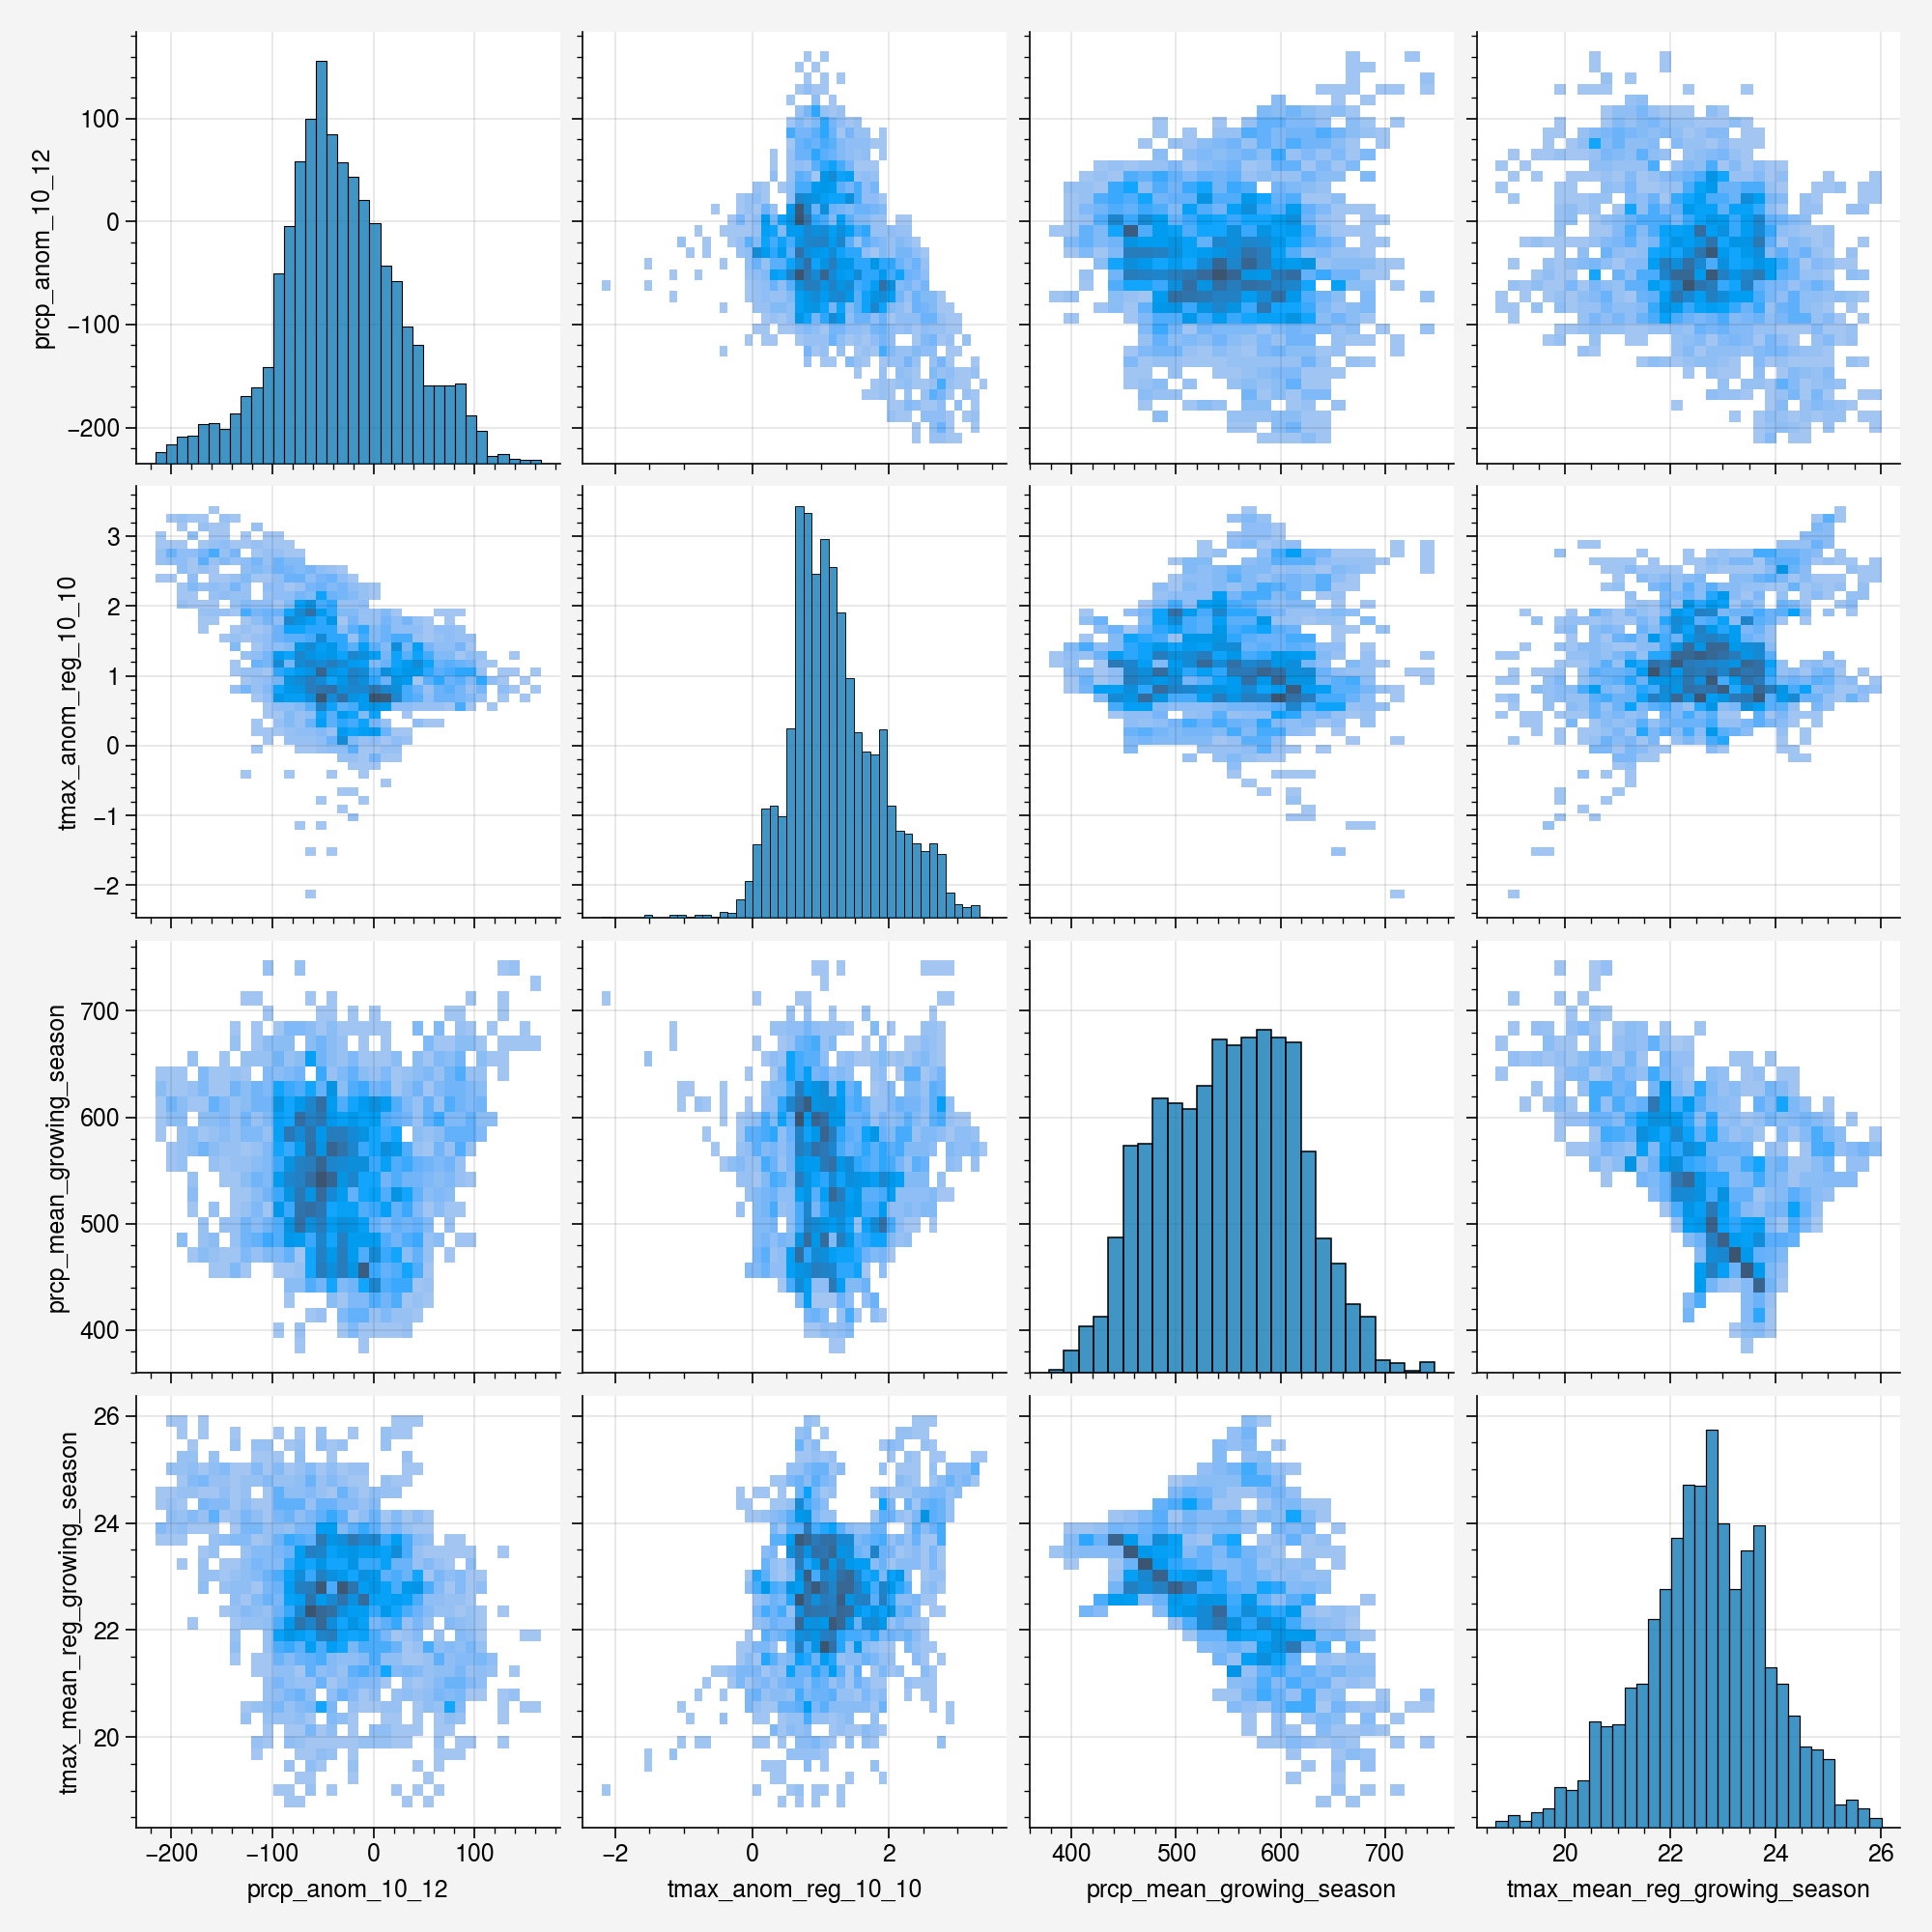

In [29]:
sns.pairplot(full_df[['prcp_anom_10_12','tmax_anom_reg_10_10','prcp_mean_growing_season','tmax_mean_reg_growing_season']], kind='hist')